In [21]:
%matplotlib inline

import os.path as fs
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io
from datetime import datetime, timedelta

DATA_DIR = '../data'
WIKI_META_FILE = 'wiki_crop/wiki.mat'
IMDB_META_FILE = 'imdb/imdb.mat'

In [2]:
lmap = lambda f, l: list(map(f, l))
lfilter = lambda f, l: list(filter(f, l))

def python_datetime(x):
    try:
        return datetime.fromordinal(int(x)) + timedelta(days=int(x)%1) - timedelta(days = 366)
    except:
        return None

python_datetime_vec = np.vectorize(python_datetime)

get_year_vec = np.vectorize(lambda x: x.year if x is not None else 0)
to_string_vec = np.vectorize(lambda x: str(x)[2:-2])

def get_meta_data(filename, key='wiki'):
    # Read input file
    meta = scipy.io.loadmat(fs.join(DATA_DIR, filename))
      
    dob_timestamp = np.asarray(meta[key][0][0][0])
    photo_taken_year = np.asarray(meta[key][0][0][1])
    full_path = np.asarray(meta[key][0][0][2])
    gender = np.asarray(meta[key][0][0][3])
    name = np.asarray(meta[key][0][0][4])
    face_location = np.asarray(meta[key][0][0][5])
    face_score = np.asarray(meta[key][0][0][6])
    face_score_2 = np.asarray(meta[key][0][0][7])
    
    # Parse Matlab date
    dob_timestamp = python_datetime_vec(dob_timestamp[0,:])
    age = photo_taken_year[0,:] - get_year_vec(dob_timestamp)
    
    return {
        'path':   to_string_vec(full_path[0,:]),
        'name':   to_string_vec(name[0,:]),
        'age':    age,
        'gender': gender[0,:].astype(int)
    }

def filter_meta_data(data, filter_mask):
    return {
        'path':   data['path'][filter_mask],
        'name':   data['name'][filter_mask],
        'age':    data['age'][filter_mask],
        'gender': data['gender'][filter_mask]
    }

def to_bins(data, bins):
    bin_labels = lmap(lambda b: '%s-%s' % b, bins)
    
    bins.append((-1, -1))
    bin_labels.append('other')
    
    binarize = lambda x: bins.index(next(filter(lambda e: x >= e[0] and x <= e[1], bins), bins[-1]))
    binarize_vec = np.vectorize(binarize)
    return binarize_vec(data), bin_labels
    
def plot_histo(data, bins=30, range=(0,100), figsize=(20,10), xticks=None):
    hist, bin_edges = np.histogram(data, bins=bins, range=range)

    plt.figure(figsize=figsize)
    plt.bar(bin_edges[:-1], hist, width=1)
    plt.xlim(min(bin_edges), max(bin_edges))
    if xticks is not None:
        plt.xticks(np.arange(len(xticks)) + 0.5, xticks)
    plt.show()

## Analyse Wiki Dataset

In [3]:
wiki_meta = get_meta_data(WIKI_DATA_DIR, WIKI_META_FILE, 'wiki')

In [4]:
wiki_meta

{'age': array([28, 39, 60, ..., 41, 30, 54]),
 'gender': array([1, 1, 1, ..., 1, 1, 0]),
 'name': array(['Sami Jauhojärvi', 'Dettmar Cramer', 'Marc Okrand', ...,
        'Michael Wiesinger', 'Johann Grugger', 'Greta Van Susteren'], 
       dtype='<U70'),
 'path': array(['17/10000217_1981-05-05_2009.jpg',
        '48/10000548_1925-04-04_1964.jpg', '12/100012_1948-07-03_2008.jpg',
        ..., '09/9998109_1972-12-27_2013.jpg',
        '00/9999400_1981-12-13_2011.jpg', '80/999980_1954-06-11_2008.jpg'], 
       dtype='<U37')}

In [5]:
# We can assume that ages above 100 are faulty
num_faulty = np.sum(wiki_meta['age'] > 100)
print('Faulty entries: %i' % num_faulty)

wiki_meta = filter_meta_data(wiki_meta, wiki_meta['age'] <= 100)

Faulty entries: 500


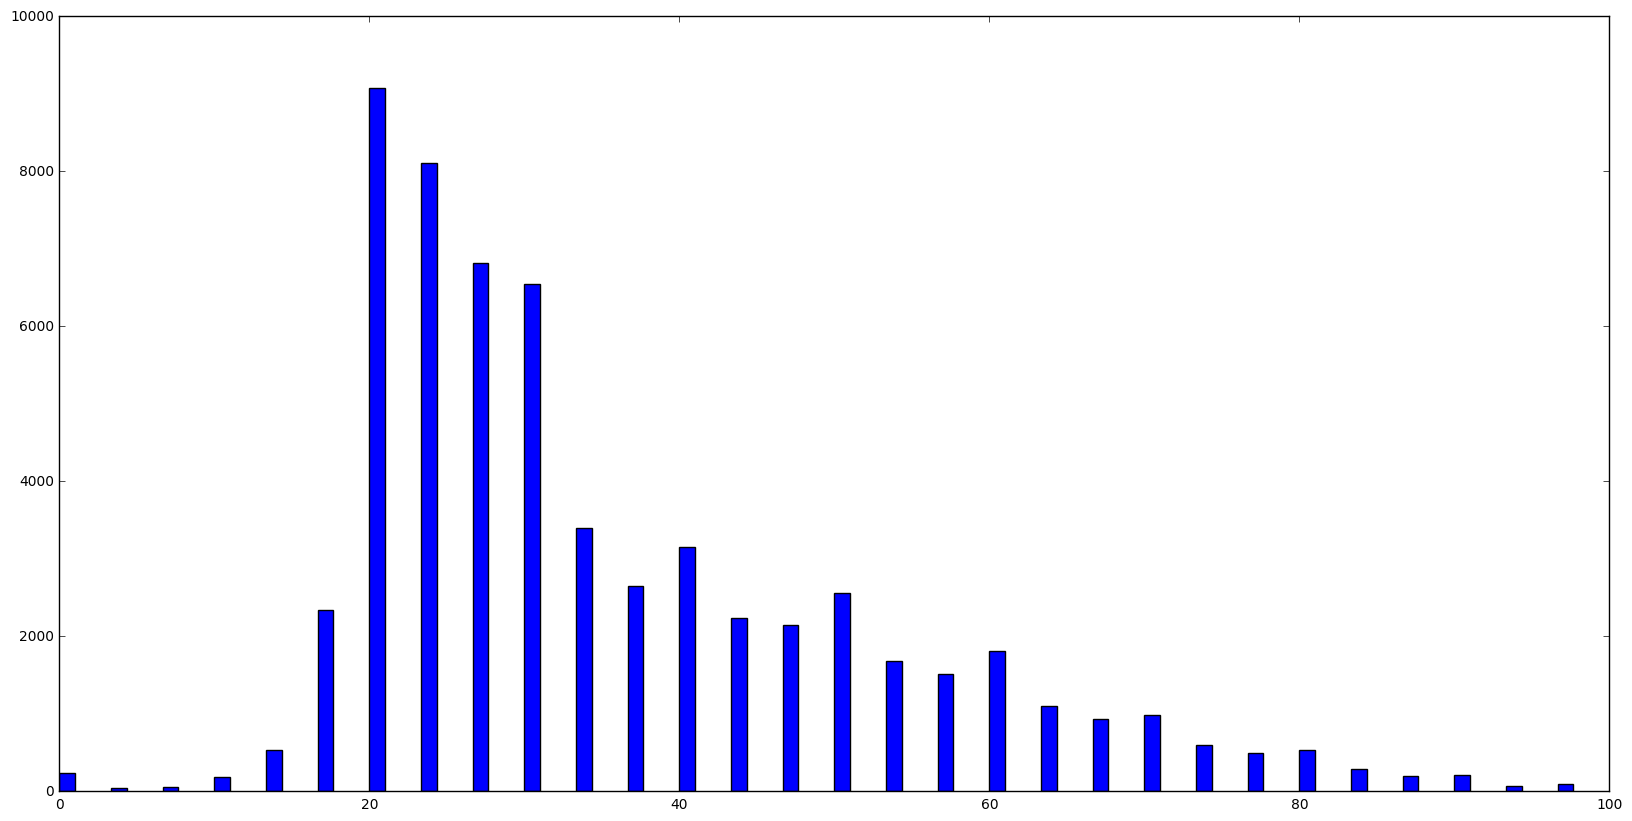

In [6]:
plot_histo(wiki_meta['age'], bins=30)

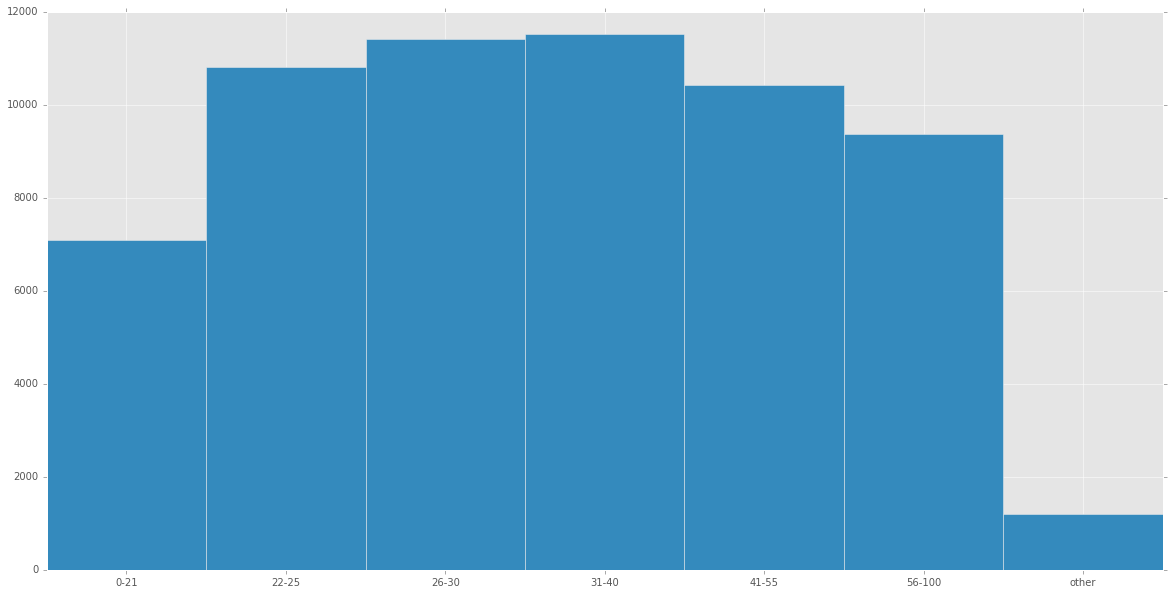

In [7]:
age_classes = [(0,21),(22,25),(26,30),(31,40),(41,55),(56,100)]

age_binned, age_labels = to_bins(wiki_meta['age'], age_classes)

plot_histo(age_binned, bins=range(len(age_labels) + 1), xticks=age_labels)

## Analyse IMDb Dataset

In [8]:
imdb_meta = get_meta_data(IMDB_META_FILE, key='imdb')

In [9]:
imdb_meta

{'age': array([69, 71, 69, ..., 22, 22, 22]),
 'gender': array([1, 1, 1, ..., 0, 0, 0]),
 'name': array(['Fred Astaire', 'Fred Astaire', 'Fred Astaire', ..., 'Jane Levy',
        'Jane Levy', 'Jane Levy'], 
       dtype='<U33'),
 'path': array(['01/nm0000001_rm124825600_1899-5-10_1968.jpg',
        '01/nm0000001_rm3343756032_1899-5-10_1970.jpg',
        '01/nm0000001_rm577153792_1899-5-10_1968.jpg', ...,
        '08/nm3994408_rm926592512_1989-12-29_2011.jpg',
        '08/nm3994408_rm943369728_1989-12-29_2011.jpg',
        '08/nm3994408_rm976924160_1989-12-29_2011.jpg'], 
       dtype='<U45')}

In [10]:
# We can assume that ages above 100 are faulty
num_faulty = np.sum(imdb_meta['age'] > 100)
print('Faulty entries: %i' % num_faulty)

imdb_meta = filter_meta_data(imdb_meta, imdb_meta['age'] <= 100)

Faulty entries: 160


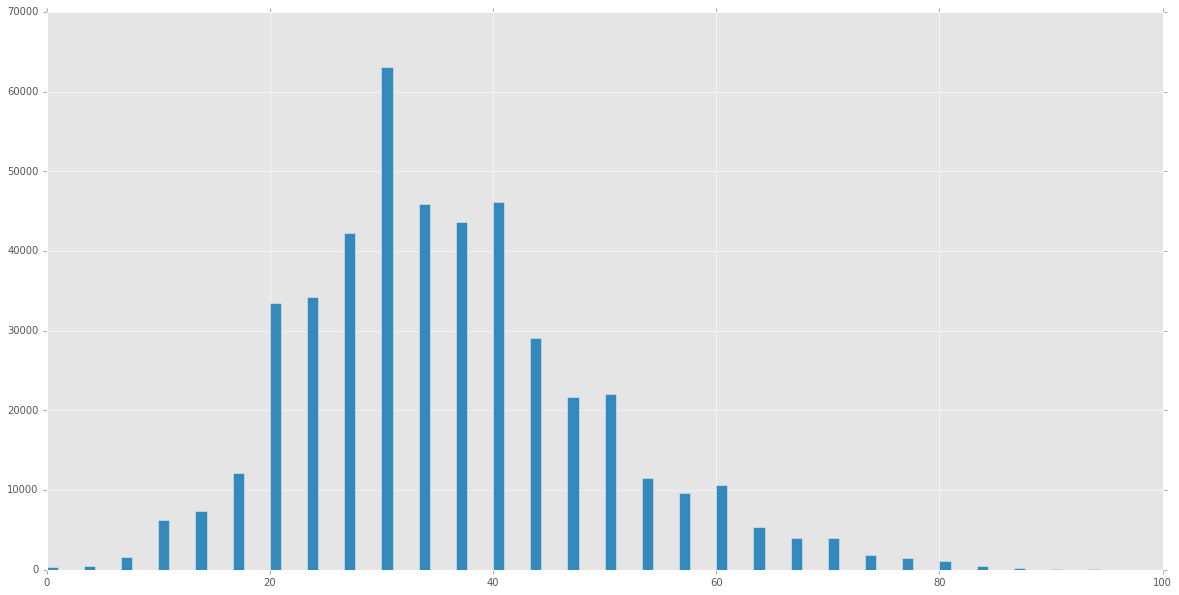

In [11]:
plot_histo(imdb_meta['age'], bins=30)

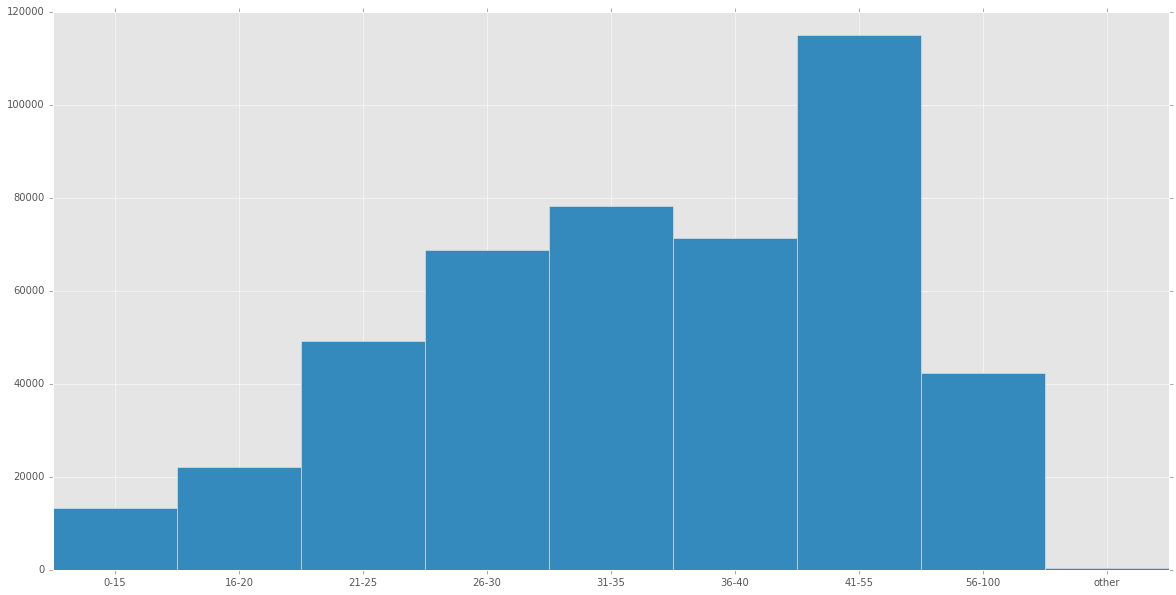

In [12]:
age_classes = [(0,15),(16,20),(21,25),(26,30),(31,35),(36,40),(41,55),(56,100)]

age_binned, age_labels = to_bins(imdb_meta['age'], age_classes)

plot_histo(age_binned, bins=range(len(age_labels) + 1), xticks=age_labels)